In [368]:
import os
import json
import re
import pandas as pd

# Annotations and Metadata
def load_json_files(folder_path):
    data = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            with open(os.path.join(folder_path, file_name), 'r') as f:
                data.append(json.load(f))
    return data

# Folders
annotations_folder = r"B:\annotations\sample\coco\annotations_06"
metadata_folder = r"B:\annotations\sample\ocular-json"

# Load all annotations and metadata
annotations = load_json_files(annotations_folder)
metadata = load_json_files(metadata_folder)

In [369]:
# Extract timestamp from file name or file path
def extract_timestamp(file_path):
    match = re.search(r'Ocular_(\d{4}-\d{2}-\d{2}_\d{2}_\d{2}_\d{2})', file_path)
    return match.group(1) if match else None

metadata_list = []
for meta in metadata:
    if isinstance(meta, dict):
        # Processing each key-value pair in the dictionary
        timestamp = extract_timestamp(meta.get('file_path', None))
        if timestamp:
            metadata_list.append({
                'timestamp': timestamp,
                'zoom_ration': meta.get('zoom_ration', None),
                'slide_name': meta.get('slide_name', None),
                'username': meta.get('username', None),
                'stain': meta.get('stain', None)
            })
        else:
            print('No timestamp found')

metadata_df = pd.DataFrame(metadata_list)

In [370]:
import pandas as pd

# Based on the timestamp pattern in the file paths match annotations to metadata
annotation_list = []
for annotation_file in annotations:
    for image in annotation_file['images']:
        file_name = image['file_name']
        image_id = image['id']
        timestamp = extract_timestamp(file_name)
        if timestamp:
            matching_metadata = metadata_df[metadata_df['timestamp'] == timestamp]
            if not matching_metadata.empty:
                for annotation in annotation_file['annotations']:
                    if annotation['image_id'] == image['id']:
                        for category in annotation_file['categories']:
                            category_name = category['name']
                            category_id = category['id']
                            if annotation['category_id'] == category_id:
                             for _, row in matching_metadata.iterrows():
                                annotation_list.append({
                                'file_name': file_name,
                                'category_id': annotation['category_id'],
                                'category_name':category_name,
                                'image_id': image_id,
                                'zoom_ration': row['zoom_ration']
                                })


sally_annotations_df = pd.DataFrame(annotation_list)

In [392]:
#sally_annotations_df.to_csv('sally_annotations_df.csv', sep=',', header=True, index=False, na_rep='NA', float_format='%.2f')

In [391]:
grouped_2 = metadata_df.groupby(['slide_name','zoom_ration']).size().reset_index(name='count')
grouped_2.columns = ['slide_name','zoom_ration','Number']
#print(grouped_2)
slides = pd.DataFrame(grouped_2)
slides.head()

,slide_name,zoom_ration,Number
0,1,1.6,1
1,126_f_eu,1.0,20
2,1487,1.0,1
3,2,1.2,1
4,DSI AYE 013-G-NU,2.8,1


In [373]:
grouped_annotations = sally_annotations_df.groupby(['image_id','zoom_ration','category_name']).size().reset_index(name='number')
#print(grouped_annotations)
slides_2 = pd.DataFrame(grouped_annotations)
slides_2.head()

,image_id,zoom_ration,category_name,number
0,1,1.0,Trophozoite,14
1,1,1.0,WBC,2
2,1,1.4,PF,5
3,1,1.6,Trophozoite,114
4,1,1.6,WBC,10


In [374]:
grouped_annotations = sally_annotations_df.groupby(['image_id','zoom_ration','category_name']).size().reset_index(name='number')
#print(grouped_annotations)
slides_2 = pd.DataFrame(grouped_annotations)
#slides_2.head(26)
slides_number = slides_2['image_id'].value_counts()
slides_number.head()

image_id
54     11
44     11
104    10
49     10
123    10
Name: count, dtype: int64

In [395]:
# Get the count of each category
category_counts = slides_2['category_name'].value_counts()
category_counts

category_name
Trophozoite    417
WBC            362
PF             261
Artifact        66
Gametocyte      56
PV              31
PM              24
Schizont        13
PO               7
Name: count, dtype: int64

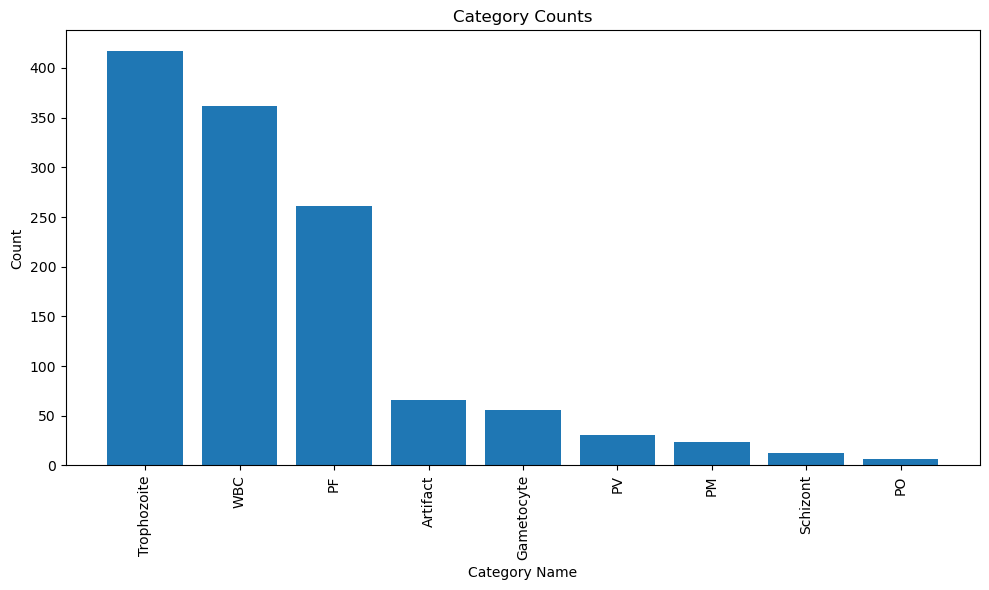

In [376]:
import matplotlib.pyplot as plt

# Get the count of each category
category_counts = slides_2['category_name'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Category Name')
plt.ylabel('Count')
plt.title('Category Counts')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [377]:
import pandas as pd
# Thick and Thin in annotations_df
sally_annotations_df['is_thick'] = sally_annotations_df['file_name'].str.contains('THICK', case=False)
sally_annotations_df['is_thin'] = sally_annotations_df['file_name'].str.contains('THIN', case=False)
annotation_thick = annotations_df['is_thick']
annotation_thin = annotations_df['is_thin']

thick_annotations = sally_annotations_df[annotation_thick]
thick_annotations = thick_annotations.drop('is_thick', axis = 1)
thick_annotations = thick_annotations.drop('is_thin', axis = 1)
thick_annotations = thick_annotations.drop('category_id', axis = 1)
thick_annotations= thick_annotations.drop('category_name', axis = 1)
thick_annotations= thick_annotations.groupby(['file_name','image_id']).size().reset_index(name='count')
length_thick_annotations = len(thick_annotations)
print(length_thick_annotations)

thin_annotations = sally_annotations_df[annotation_thin]
thin_annotations = thin_annotations.drop('is_thick', axis = 1)
thin_annotations = thin_annotations.drop('is_thin', axis = 1)
thin_annotations = thin_annotations.drop('category_id', axis = 1)
thin_annotations = thin_annotations.drop('category_name', axis = 1)
length_thin_annotations = len(thin_annotations)
print(length_thin_annotations)

262
4513


In [378]:
# Thick and Thin in metadata_df
metadata_df['is_thick'] = metadata_df['slide_name'].str.contains('THICK', case=False)
metadata_df['is_thin'] = metadata_df['slide_name'].str.contains('THIN', case=False)
metadata_thick = metadata_df['is_thick']
metadata_thin = metadata_df['is_thin']

thick_meta = metadata_df[metadata_thick]
thick_meta = thick_meta.drop('is_thick', axis = 1)
thick_meta = thick_meta.drop('is_thin', axis = 1)
thick_meta = thick_meta.drop('stain', axis = 1)
thick_meta = thick_meta.drop('username', axis = 1)
thick_meta = thick_meta.groupby(['timestamp','slide_name','zoom_ration']).size().reset_index(name='Number')
thick_meta = thick_meta.drop('Number', axis = 1)
length_thick_meta = len(thick_meta)
print(length_thick_meta)

thin_meta = metadata_df[metadata_thin]
thin_meta = thin_meta.drop('is_thick', axis = 1)
thin_meta = thin_meta.drop('is_thin', axis = 1)
thin_meta = thin_meta.drop('stain', axis = 1)
thin_meta = thin_meta.drop('username', axis = 1)
thin_meta = thin_meta.groupby(['timestamp','slide_name','zoom_ration']).size().reset_index(name='Number')
thin_meta = thin_meta.drop('Number', axis = 1)
length_thin_meta = len(thin_meta)
print(length_thin_meta)

2661
2472


In [393]:
import numpy as np
trophozoite_annotations = sally_annotations_df[sally_annotations_df['category_id'] == 1]

# Create a mapping of category_id to category_name
category_mapping = sally_annotations_df.groupby('category_id')['category_name'].first()

# Replacing category_id with category_name in the groupby column
trophozoite_annotations.loc[:,'category_id'] = trophozoite_annotations['category_id'].map(category_mapping)

trophozoite_annotations = trophozoite_annotations.groupby(['image_id','category_id']).size().reset_index(name='Number')
trophozoite_annotations.columns = ['Image_ID','Category_name','Number']
#sally_trop_annot = trophozoite_annotations
#sally_trop_annot.head()
#sally_trop_annot_number = len(sally_trop_annot)
#sally_trop_annot_number

200

In [398]:
# For Thick
trophozoite_annotations['is_thick'] = metadata_df['slide_name'].str.contains('THICK', case=False)
sally_trophozoite_thick = trophozoite_annotations['is_thick']

# New column indicating whether the slide is thick or thin
trophozoite_annotations.loc[:, 'Slide_Name'] = np.where(trophozoite_thick, 'Thick','Thin')
trophozoite_annotations_thick = trophozoite_annotations[trophozoite_thick]
trophozoite_annotations_thick = trophozoite_annotations_thick.drop('is_thick', axis = 1)
trophozoite_annotations_thick.head()
trophozoite_annotations_number_thick  = len(trophozoite_annotations_thick)
trophozoite_annotations_number_thick 

114

In [397]:
# For Thin
trophozoite_annotations['is_thin'] = metadata_df['slide_name'].str.contains('THIN', case=False)
trophozoite_thin = trophozoite_annotations['is_thin']
# For Zoomratio
#trophozoite_annotations['zoom_ration'] = metadata_df['zoom_ration']

# New column indicating whether the slide is thick or thin
trophozoite_annotations.loc[:, 'Slide_Name'] = np.where(trophozoite_thin, 'Thin','Thick')
trophozoite_annotations_thin = trophozoite_annotations[trophozoite_thin]
trophozoite_annotations_thin = trophozoite_annotations_thin.drop('is_thin', axis = 1)
trophozoite_annotations_thin = trophozoite_annotations_thin.drop('is_thick', axis = 1)
trophozoite_annotations_thin.head()
trophozoite_annotations_number_thin  = len(trophozoite_annotations_thin)
trophozoite_annotations_number_thin

86

In [382]:
schizont_annotations = sally_annotations_df[sally_annotations_df['category_id'] == 2]

schizont_annotations = schizont_annotations.groupby(['image_id']).size().reset_index(name='Number')
schizont_annotations['category_id'] = 2

category_mapping = sally_annotations_df[['category_id', 'category_name']].drop_duplicates()
schizont_annotations.loc[:,'category_id'] = schizont_annotations['category_id'].replace(category_mapping.set_index('category_id')['category_name'])
schizont_annotations.columns = ['Image_ID','Number','Category_name']
print(schizont_annotations.head())

   Image_ID  Number Category_name
0        20       1      Schizont
1        78       1      Schizont
2        85       2      Schizont
3       157       1      Schizont
4       158       1      Schizont


In [383]:
gametocyte_annotations = sally_annotations_df[sally_annotations_df['category_id'] == 3]

gametocyte_annotations = gametocyte_annotations.groupby(['image_id']).size().reset_index(name='Number')
gametocyte_annotations['category_id'] = 3

category_mapping = sally_annotations_df[['category_id', 'category_name']].drop_duplicates()
gametocyte_annotations.loc[:,'category_id'] = gametocyte_annotations['category_id'].replace(category_mapping.set_index('category_id')['category_name'])
gametocyte_annotations.columns = ['Image_ID','Number','Category_name']
gametocyte_annotations.head()

,Image_ID,Number,Category_name
0,3,1,Gametocyte
1,4,1,Gametocyte
2,5,1,Gametocyte
3,12,1,Gametocyte
4,13,1,Gametocyte


In [384]:
wbc_annotations = annotations_df[annotations_df['category_id'] == 4]
wbc_annotations = wbc_annotations.drop('is_thick', axis = 1)
wbc_annotations = wbc_annotations.drop('is_thin', axis = 1)
wbc_annotations = wbc_annotations.groupby(['image_id','category_id']).size().reset_index(name='count')
wbc_annotations.head()

,image_id,category_id,count
0,1,4,16
1,2,4,18
2,3,4,13
3,4,4,11
4,5,4,13
